In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium

In [2]:
# Load the dataset into a Pandas DataFrame
file_path = '/content/drive/MyDrive/Colab/NU/IE6200/stations.csv'
stations_df = pd.read_csv(file_path)
stations_df.head()

,Number,NAME,Lat,Long,Seasonal Status,Municipality,Total Docks
0,L32001,Railroad Lot and Minuteman Bikeway,42.416065,-71.153366,Year Round,Arlington,11.0
1,L32002,Linwood St at Minuteman Bikeway,42.409354,-71.149065,Year Round,Arlington,11.0
2,L32005,Thorndike Field at Minuteman Bikeway,42.400168,-71.144570,Year Round,Arlington,11.0
3,L32003,Mass Ave at Grafton St,42.407261,-71.143821,Winter Storage,Arlington,11.0
4,L32004,Broadway at Grafton St,42.409942,-71.140093,Winter Storage,Arlington,11.0


In [3]:
# Missing values
missing_values = stations_df.isnull().sum()
missing_values

,0
Number,0
NAME,0
Lat,0
Long,0
Seasonal Status,6
Municipality,0
Total Docks,6


In [4]:
# Number of rows with at least one missing value
missing_value_count = stations_df[stations_df.isnull().any(axis=1)].shape[0]
print(f"Number of rows with at least one missing value: {missing_value_count}")

Number of rows with at least one missing value: 6


In [5]:
# Remove rows with any missing values
stations_df = stations_df.dropna()

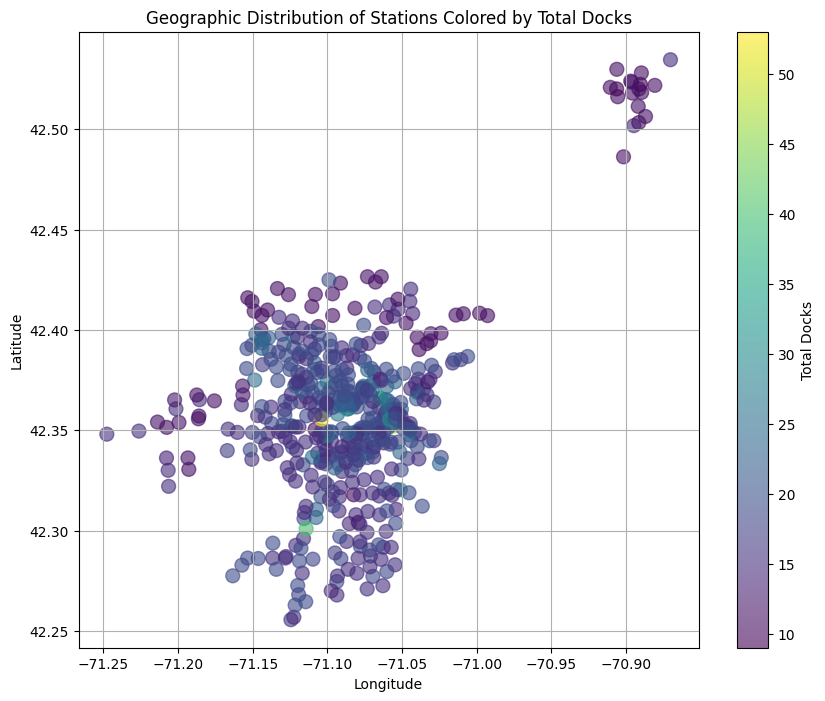

In [6]:
# Geographic Distribution of Stations Colored by Total Docks
plt.figure(figsize=(10, 8))
plt.scatter(stations_df['Long'], stations_df['Lat'], c=stations_df['Total Docks'], cmap='viridis', s=100, alpha=0.6)
plt.colorbar(label='Total Docks')
plt.title('Geographic Distribution of Stations Colored by Total Docks')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

In [7]:
# An Interactive Map Visualizing Station Locations
m = folium.Map(location=[stations_df['Lat'].mean(), stations_df['Long'].mean()], zoom_start=12)

# Add stations to the map
for idx, row in stations_df.iterrows():
    folium.CircleMarker(
        location=(row['Lat'], row['Long']),
        radius=row['Total Docks'] / 2,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.6,
        popup=row['NAME']
    ).add_to(m)

# Save the map to an HTML file
m.save('stations_map.html')

# Display the map
m

[View Stations Map](https://natdave.github.io/IE6200/stations_map.html)

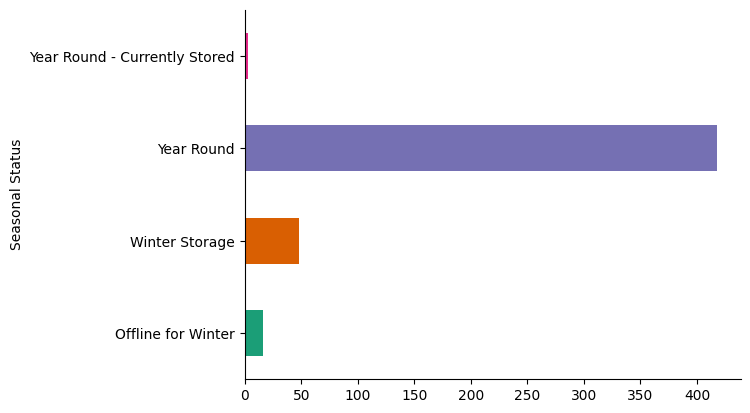

In [8]:
# Horizontal Bar Plot of Seasonal Status Distribution
stations_df.groupby('Seasonal Status').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

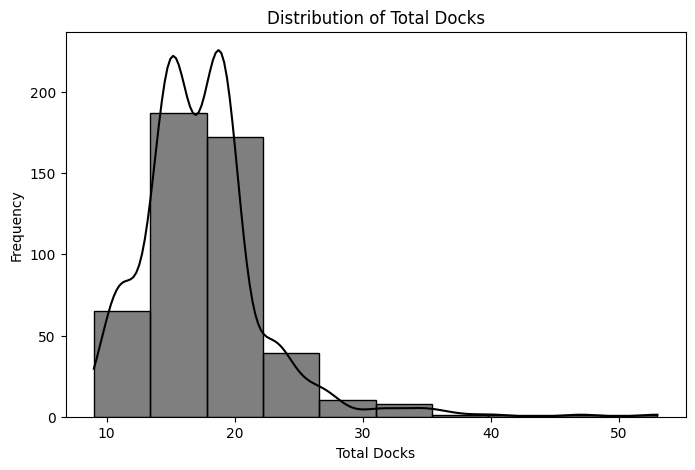

In [9]:
# Distribution of total docks
plt.figure(figsize=(8, 5))
sns.histplot(stations_df['Total Docks'], bins=10, color='black', kde=True)
plt.title('Distribution of Total Docks')
plt.xlabel('Total Docks')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

<ipython-input-10-1dcb40de9850>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Municipality', y='Total Docks', data=stations_df, palette='Set3')


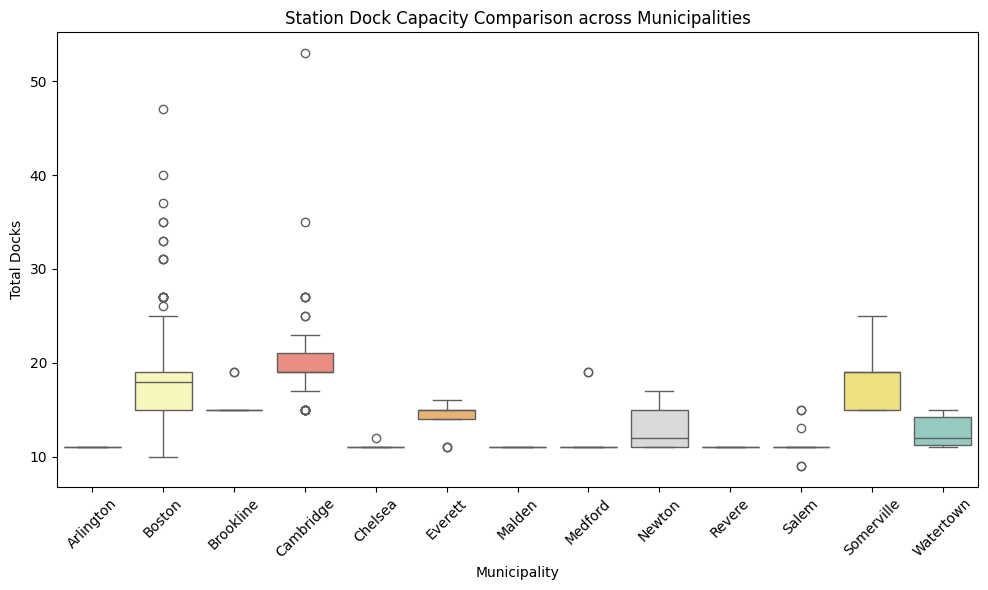

In [10]:
# Station Dock Capacity Comparison (Box Plot)
plt.figure(figsize=(10, 6))
sns.boxplot(x='Municipality', y='Total Docks', data=stations_df, palette='Set3')
plt.title('Station Dock Capacity Comparison across Municipalities')
plt.xlabel('Municipality')
plt.ylabel('Total Docks')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

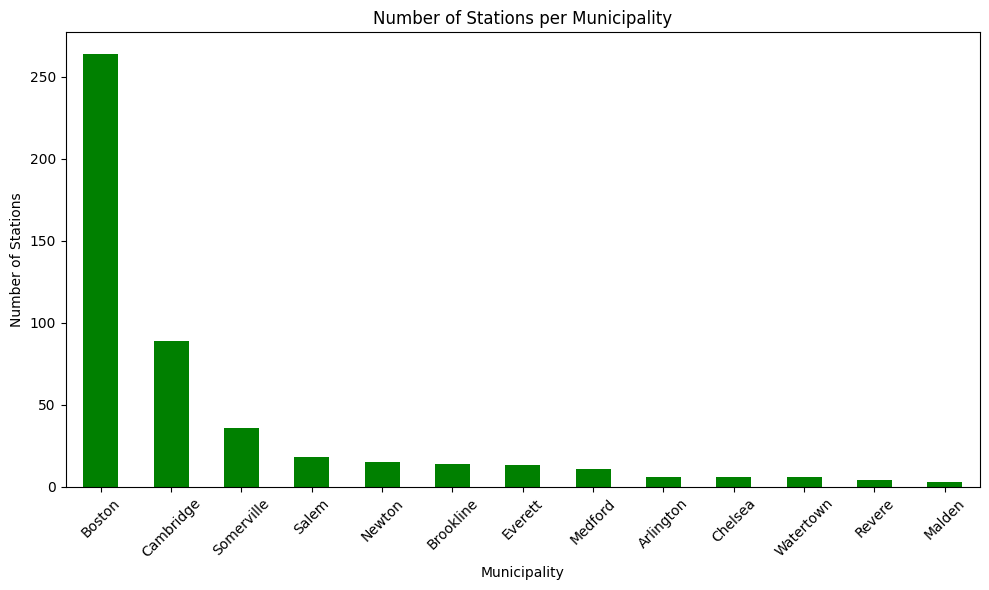

In [11]:
# Number of Stations per Municipality
plt.figure(figsize=(10, 6))
stations_per_municipality = stations_df['Municipality'].value_counts()
stations_per_municipality.plot(kind='bar', color='green')
plt.title('Number of Stations per Municipality')
plt.xlabel('Municipality')
plt.ylabel('Number of Stations')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

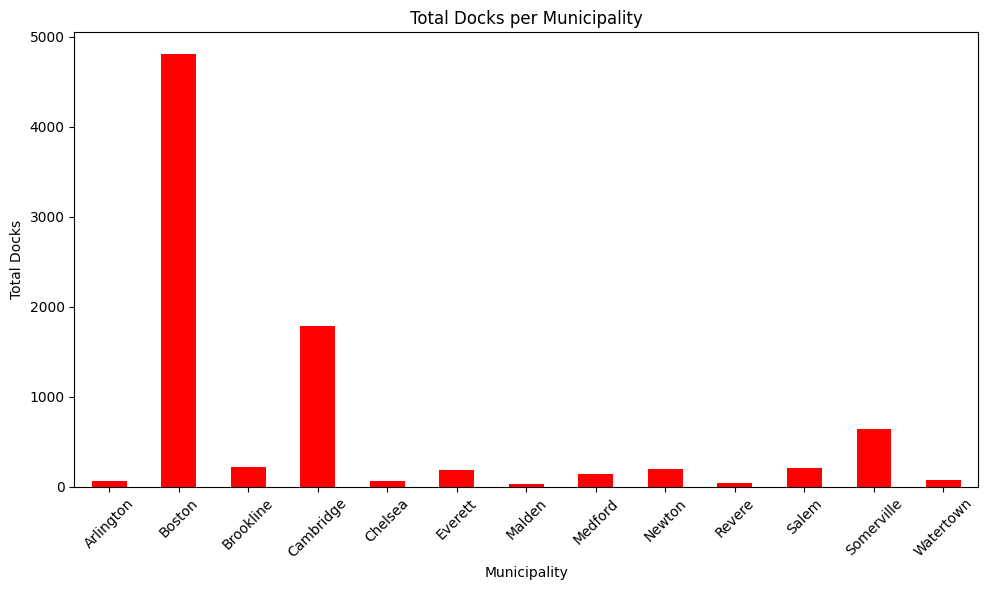

In [12]:
# Total Docks per Municipality
plt.figure(figsize=(10, 6))
docks_per_municipality = stations_df.groupby('Municipality')['Total Docks'].sum()
docks_per_municipality.plot(kind='bar', color='red')
plt.title('Total Docks per Municipality')
plt.xlabel('Municipality')
plt.ylabel('Total Docks')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

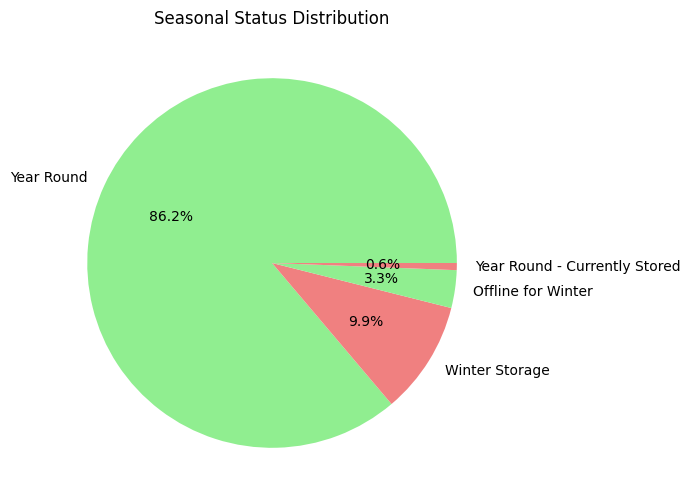

In [13]:
# Seasonal Status Distribution
plt.figure(figsize=(6, 6))
seasonal_status_counts = stations_df['Seasonal Status'].value_counts()
seasonal_status_counts.plot(kind='pie', autopct='%1.1f%%', colors=['lightgreen', 'lightcoral'])
plt.title('Seasonal Status Distribution')
plt.ylabel('')  # Remove y-label
plt.show()

In [14]:
# Function to convert DMS coordinates to decimal
def dms_to_decimal(dms):
    parts = dms.strip().split()
    degrees = float(parts[0])
    minutes = float(parts[1])
    seconds = float(parts[2])
    direction = parts[3]

    # Calculate the decimal value
    decimal = degrees + minutes / 60 + seconds / 3600

    # Apply negative for 'S' or 'W' directions
    if direction in ['S', 'W']:
        decimal *= -1

    return decimal

In [15]:
dms_lat = "42 21 37.4 N"
dms_lon = "71 03 28.8 W"
lat = dms_to_decimal(dms_lat)
lon = dms_to_decimal(dms_lon)

print(f'Coordinates ({dms_lat}, {dms_lon}) correspond to ({lat:.6f}, {lon:.6f})')

Coordinates (42 21 37.4 N, 71 03 28.8 W) correspond to (42.360389, -71.058000)


In [16]:
# Function to find stations within a specified radius (in ft) of a given lat/lng
def find_stations_within_radius(lat, lon, radius_ft, stations_df):
    # Calculate distances in feet using Haversine formula
    stations_df['distance'] = (
        5280 * 3959 * np.arccos(
            np.clip(
                np.sin(np.radians(lat)) * np.sin(np.radians(stations_df['Lat'])) +
                np.cos(np.radians(lat)) * np.cos(np.radians(stations_df['Lat'])) *
                np.cos(np.radians(stations_df['Long']) - np.radians(lon)), -1.0, 1.0
            )
        )
    )
    return stations_df[stations_df['distance'] <= radius_ft]

In [17]:
# Find stations within specified number of feet from the provided coordinates
stations_within_radius = find_stations_within_radius(42.349495, -71.100575, 1000, stations_df)
stations_within_radius.reset_index(drop=True)

,Number,NAME,Lat,Long,Seasonal Status,Municipality,Total Docks,distance
0,B32037,Deerfield St at Commonwealth Ave,42.349244,-71.097282,Year Round,Boston,19.0,892.589209
1,B32058,Lansdowne T Stop,42.347345,-71.100168,Year Round,Boston,27.0,792.129901
2,B32060,700 Commonwealth Ave.,42.349609,-71.103915,Year Round,Boston,16.0,901.599807
3,D32032,Silber Way,42.349496,-71.100576,Year Round,Boston,19.0,0.440509


In [24]:
# Create a grid of points within the min/max range of station coordinates
lat_range = np.linspace(stations_df['Lat'].min(), stations_df['Lat'].max(), 100)
lon_range = np.linspace(stations_df['Long'].min(), stations_df['Long'].max(), 100)

max_stations_count = 0
best_location = None
stations_within_best_radius = None

# Check each point in the grid to find which has the most stations within the specified radius (ft)
for lat in lat_range:
    for lon in lon_range:
        nearby_stations = find_stations_within_radius(lat, lon, 1000, stations_df)
        count = nearby_stations.shape[0]

        if count > max_stations_count:
            max_stations_count = count
            best_location = (lat, lon)
            stations_within_best_radius = nearby_stations  # Store stations within the best radius

# Create a map centered at the best location
m = folium.Map(location=best_location, zoom_start=15)

# Add a circle with a fixed radius (in ft) around the best location
# Convert feet to meters for folium (1 foot = 0.3048 meters)
folium.Circle(
    location=best_location,
    radius=1000 * 0.3048,  # 1000 feet in meters
    color='red',
    fill=True,
    fill_opacity=0.4,
    popup=f'Best location with {max_stations_count} stations'
).add_to(m)

# Add markers for stations ONLY within the 1000-foot radius
for idx, row in stations_within_best_radius.iterrows():
    folium.Marker(
        location=(row['Lat'], row['Long']),
        popup=row['NAME']
    ).add_to(m)

# Save the map to an HTML file
m.save('best_location_1000ft_map.html')

# Display the map
m